In [182]:
# === CELL 0: GLOBALS (bắt buộc) ===
import os, json, re, math, numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from model.mtl_cnn import mtl_cnn_v1
from model.mobilenet_v4 import CustomMobileNetV4 as MobileNetV4
from model.efficientnet_b0 import CustomEfficientNetB0
# 0.1) Class names chuẩn (đặt đúng thứ tự bạn muốn báo cáo)
CLASS_NAMES = [
    "Banh beo","Banh bot loc","Banh can","Banh canh","Banh chung","Banh cuon","Banh duc","Banh gio",
    "Banh khot","Banh mi","Banh pia","Banh tet","Banh trang nuong","Banh xeo","Bun bo Hue","Bun dau mam tom",
    "Bun mam","Bun rieu","Bun thit nuong","Ca kho to","Canh chua","Cao lau","Chao long","Com tam",
    "Goi cuon","Hu tieu","Mi quang","Nem chua","Pho","Xoi xeo","banh_da_lon","banh_tieu","banh_trung_thu"
]
NUM_CLASSES = len(CLASS_NAMES)

# 0.2) Thư mục dữ liệu & output
ROOT = "C:/TRAIN/Deep Learning/vietnamese-foods/Images"
TEST_DIR = f"{ROOT}/Test"
RUNS_DIR = "./Runs"       # thư mục cha chứa các run
IMAGES_DIR = "./images"
os.makedirs(IMAGES_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH = 64

In [183]:
# === CELL 1: BUILD TEST LOADER ===
def build_test_loader(test_dir=TEST_DIR, img_size=IMG_SIZE, batch_size=BATCH):
    tfm = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        # nếu lúc train có Normalize(...) thì thêm vào đúng mean/std tại đây
    ])
    ds = datasets.ImageFolder(test_dir, transform=tfm)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return loader, ds

In [184]:
# === CELL 2: MODEL FACTORY & CHECKPOINT LOADER (AN TOÀN) ===
def model_auto(run_name:str, num_classes:int=NUM_CLASSES):
    n = run_name.lower()
    if "mobilenetv4" in n or "mobile" in n:
        return MobileNetV4(num_classes=num_classes)
    if "efficientnet" in n or "b0" in n:
        return CustomEfficientNetB0(num_classes=num_classes)
    # mặc định: mô hình CNN tự xây
    return mtl_cnn_v1(num_classes=num_classes)

def pick_checkpoint(run_path: str):
    """Ưu tiên best.mtl, sau đó *.mtl, *.pt, *.pth trong folder checkpoints/"""
    ckdir = os.path.join(run_path, "checkpoints")
    cand = []
    if os.path.isdir(ckdir):
        for f in os.listdir(ckdir):
            if f.lower().endswith((".mtl",".pt",".pth")):
                cand.append(os.path.join(ckdir,f))
    # ưu tiên best.*
    cand = sorted(cand, key=lambda p: (0 if os.path.basename(p).lower().startswith("best") else 1, p))
    return cand[0] if cand else None

def load_checkpoint(model, ckpt_path, device=DEVICE):
    state = torch.load(ckpt_path, map_location=device)
    # hỗ trợ nhiều định dạng state
    if isinstance(state, dict) and "state_dict" in state:
        sd = state["state_dict"]
    elif isinstance(state, dict) and "net" in state:
        sd = state["net"]
    else:
        sd = state
    # bỏ tiền tố 'module.' nếu có
    new_sd = {}
    for k, v in sd.items():
        nk = k.replace("module.", "")
        new_sd[nk] = v
    missing, unexpected = model.load_state_dict(new_sd, strict=False)
    if missing:   print("[load] missing keys:", missing)
    if unexpected:print("[load] unexpected keys:", unexpected)
    model.to(device).eval()
    return model

In [185]:
# === CELL 3: COLLECT LOGITS (ỔN ĐỊNH NHÃN) ===
@torch.no_grad()
def collect_logits(model, loader, device=DEVICE, class_names=CLASS_NAMES):
    # Nếu thứ tự dataset khác CLASS_NAMES -> remap
    ds = loader.dataset
    remap = None
    if hasattr(ds, "classes"):
        ds_names = list(ds.classes)
        name2idx = {n:i for i,n in enumerate(class_names)}
        # map index dataset -> index chuẩn
        remap = {i: name2idx[n] for i,n in enumerate(ds_names)}
    y_true, y_pred, y_prob = [], [], []
    for x, y in loader:
        x = x.to(device)
        if remap is not None:
            y = torch.as_tensor([remap[int(t)] for t in y], dtype=torch.long)
        logits = model(x).detach().cpu()
        prob = F.softmax(logits, dim=1).numpy()
        pred = prob.argmax(1)
        y_true.append(y.numpy())
        y_pred.append(pred)
        y_prob.append(prob)
    return np.concatenate(y_true), np.concatenate(y_pred), np.concatenate(y_prob)

In [186]:
# === CELL 4: PLOT CONFUSION MATRIX ===
def plot_confusion_matrix(y_true, y_pred, class_names, title, out_png):
    cm_counts = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    cm = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)
    cm = np.nan_to_num(cm)

    THRESHOLD = 0.10  # 10%
    fig, ax = plt.subplots(figsize=(12, 10), dpi=180)
    sns.heatmap(cm, vmin=0, vmax=1, cmap="Blues", square=True, cbar_kws={'shrink': .7},
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            show = (i == j) or (cm[i, j] >= THRESHOLD)
            if show and cm_counts[i, j] > 0:
                ax.text(j+0.5, i+0.5, f"{cm[i,j]*100:.0f}%\n({cm_counts[i,j]})",
                        ha="center", va="center", fontsize=7, color="black")
    ax.set_xlabel("Predicted", fontsize=11)
    ax.set_ylabel("True", fontsize=11)
    ax.set_title(title, fontsize=13, pad=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Saved:", out_png)

In [187]:
# === CELL 6 
def _read_cfg_size_batch(run_path, default_img=IMG_SIZE, default_bs=BATCH):
    """Đọc img_size, batch_size từ config.json (nếu có); fallback về global."""
    img_size, batch_size = default_img, default_bs
    cfg_path = os.path.join(run_path, "config.json")
    if os.path.isfile(cfg_path):
        try:
            import json
            with open(cfg_path, "r", encoding="utf-8") as f:
                cfg = json.load(f)
            # linh hoạt tên khóa
            for k in ["img_size", "image_size", "input_size", "IMG_SIZE"]:
                if k in cfg: img_size = int(cfg[k]) if isinstance(cfg[k], (int, float)) else img_size
            for k in ["batch_size", "BATCH", "bs"]:
                if k in cfg: batch_size = int(cfg[k]) if isinstance(cfg[k], (int, float)) else batch_size
        except Exception as e:
            print(f"[warn] Không đọc được config.json: {e}")
    return img_size, batch_size

In [188]:

# === CELL 7 
def evaluate_one_run(run_path: str, return_preds: bool = False):
    run_name = os.path.basename(run_path.rstrip(os.sep))
    ckpt = pick_checkpoint(run_path)
    if not ckpt:
        print(f"⚠️  {run_name}: không tìm thấy checkpoint trong {run_path}/checkpoints/")
        return None if not return_preds else (None, None)

    run_img, run_bs = _read_cfg_size_batch(run_path, IMG_SIZE, BATCH)
    test_loader, _ = build_test_loader(TEST_DIR, run_img, run_bs)

    model = model_auto(run_name, NUM_CLASSES)
    model = load_checkpoint(model, ckpt, DEVICE)

    y_true, y_pred, _ = collect_logits(model, test_loader, DEVICE, CLASS_NAMES)

    # tính metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    # vẽ CM
    title = f"Confusion Matrix (row-norm) – {run_name}"
    out_png = os.path.join(IMAGES_DIR, f"{run_name}_cm.png")
    plot_confusion_matrix(y_true, y_pred, CLASS_NAMES, title, out_png)

    info = {
        "run": run_name,
        "acc": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "img_size": int(run_img),
        "batch_size": int(run_bs),
    }
    return info if not return_preds else (info, (y_true, y_pred))


In [189]:
# === CELL 8: Top-K confused pairs (hàm độc lập, gọi lại ở Cell 6) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def top_confused_pairs(y_true, y_pred, class_names, topk=20, min_count=1):
    """
    Tính Top-K cặp dễ nhầm nhất dựa trên Confusion Matrix chuẩn hoá theo hàng (recall-row).
    Trả về list [(i, j, ratio, count), ...] với i!=j, đã sort giảm dần theo ratio rồi count.
    - ratio: tỉ lệ nhầm (phần trăm theo hàng)
    - count: số mẫu nhầm thực tế
    """
    n = len(class_names)
    cm_counts = confusion_matrix(y_true, y_pred, labels=range(n))
    row_sum = cm_counts.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm_counts, np.maximum(row_sum, 1), where=row_sum != 0)

    pairs = []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            c = int(cm_counts[i, j])
            if c < min_count:
                continue
            r = float(cm_norm[i, j])
            if r > 0:
                pairs.append((i, j, r, c))

    # sort theo tỉ lệ nhầm (desc), rồi theo count (desc)
    pairs.sort(key=lambda x: (x[2], x[3]), reverse=True)
    return pairs[:topk]

def plot_top_confusions(y_true, y_pred, class_names, run_name,
                        topk=20, min_count=1, out_dir=IMAGES_DIR):
    """
    Vẽ bar chart Top-K cặp dễ nhầm nhất & lưu ảnh:
    images/{run_name}_top{topk}_confused.png
    """
    pairs = top_confused_pairs(y_true, y_pred, class_names, topk=topk, min_count=min_count)
    if not pairs:
        print(f"[{run_name}] Không đủ mẫu để vẽ top-confusions.")
        return None

    labels = [f"{class_names[i]} → {class_names[j]}" for (i, j, _, _) in pairs]
    ratios = [p[2]*100 for p in pairs]
    counts = [p[3] for p in pairs]

    fig_h = max(5, 0.45*len(pairs)+1.5)
    fig, ax = plt.subplots(figsize=(10, fig_h), dpi=180)
    y_pos = np.arange(len(pairs))

    ax.barh(y_pos, ratios)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_xlabel("Tỉ lệ nhầm (%)")
    ax.set_title(f"Top-{topk} cặp dễ nhầm nhất – {run_name}")

    # annotate % và (count)
    for y, r, c in zip(y_pos, ratios, counts):
        ax.text(r + 0.5, y, f"{r:.1f}% ({c})", va="center")

    plt.tight_layout()
    out_png = os.path.join(out_dir, f"{run_name}_top{topk}_confused.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Saved:", out_png)
    return out_png


In [190]:
# === CELL 9: Làm gì đó ghi vào ===

In [191]:
# === CELL 10: Làm gì đó ghi vào ===

In [192]:
# === CELL 11: Làm gì đó ghi vào ===

In [193]:
# === CELL 12: Làm gì đó ghi vào ===

In [194]:
# === CELL 100: tổng hợp & render bảng cột đẹp ===
def _render_summary_table(df, out_path):
    import matplotlib.pyplot as plt
    # định dạng số 3 chữ số thập phân
    show_df = df.copy()
    for c in ["acc","precision","recall","f1"]:
        if c in show_df.columns:
            show_df[c] = show_df[c].map(lambda x: f"{x:.3f}")
    show_df["img_size"] = show_df["img_size"].astype(str)
    show_df["batch_size"] = show_df["batch_size"].astype(str)

    fig_h = 0.6 * (len(show_df) + 1) + 1
    fig, ax = plt.subplots(figsize=(12, fig_h), dpi=220)
    ax.axis("off")
    tbl = ax.table(
        cellText=show_df.values,
        colLabels=show_df.columns,
        loc='center',
        cellLoc='center',
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1, 1.2)
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Saved:", out_path)

def evaluate_entry(path_or_parent: str):
    path_or_parent = path_or_parent.rstrip(os.sep)
    results = []

    if os.path.isdir(os.path.join(path_or_parent, "checkpoints")):
        # 1 run
        print(f"Đánh giá: {os.path.basename(path_or_parent)}")
        res = evaluate_one_run(path_or_parent)
        if res: results.append(res)
    else:
        # thư mục cha
        for name in sorted(os.listdir(path_or_parent)):
            run_path = os.path.join(path_or_parent, name)
            if not os.path.isdir(run_path): 
                continue
            if not os.path.isdir(os.path.join(run_path, "checkpoints")):
                continue
            print(f"Đánh giá: {name}")
            res = evaluate_one_run(run_path)
            if res: results.append(res)

    if results:
        import pandas as pd
        df = pd.DataFrame(results).sort_values("acc", ascending=False)
        display(df)  # bảng tương tác trong notebook

        # xuất ảnh bảng
        out_png = os.path.join(IMAGES_DIR, "summary_models.png")
        _render_summary_table(df[["run","acc","precision","recall","f1","img_size","batch_size"]], out_png)
    else:
        print("⚠️  Không có mô hình hợp lệ.")


In [195]:
# === CELL 101: EVALUATE ALL RUNS & RANKING + Top-20 confused pairs ===
def evaluate_entry(path_or_parent: str, topk_pairs: int = 20, min_count: int = 1):
    path_or_parent = path_or_parent.rstrip(os.sep)
    results = []

    def _eval_and_draw(run_path):
        run_name = os.path.basename(run_path.rstrip(os.sep))
        print(f"Đánh giá: {run_name}")
        out = evaluate_one_run(run_path, return_preds=True)
        if not out or out[0] is None:
            return
        info, (y_true, y_pred) = out
        results.append(info)

        # 🔹 vẽ Top-K cặp dễ nhầm
        try:
            plot_top_confusions(y_true, y_pred, CLASS_NAMES, info["run"],
                                topk=topk_pairs, min_count=min_count, out_dir=IMAGES_DIR)
        except Exception as e:
            print(f"[warn] Không vẽ được top-confusions cho {info['run']}: {e}")

    # 1 run hay folder cha
    if os.path.isdir(os.path.join(path_or_parent, "checkpoints")):
        _eval_and_draw(path_or_parent)
    else:
        for name in sorted(os.listdir(path_or_parent)):
            run_path = os.path.join(path_or_parent, name)
            if not os.path.isdir(run_path): 
                continue
            if not os.path.isdir(os.path.join(run_path, "checkpoints")):
                continue
            _eval_and_draw(run_path)

    # tổng hợp
    if results:
        import pandas as pd
        df = pd.DataFrame(results).sort_values("acc", ascending=False)
        display(df)

        # render bảng ảnh đẹp (giữ hàm _render_summary_table bạn đang có)
        out_png = os.path.join(IMAGES_DIR, "summary_models.png")
        _render_summary_table(df[["run","acc","precision","recall","f1","img_size","batch_size"]], out_png)
    else:
        print("⚠️  Không có mô hình hợp lệ.")


In [196]:
# === CELL 102: Đánh giá một mô hình cụ thể (thư mục có checkpoints/ ===
# evaluate_entry(os.path.join(RUNS_DIR, "mtl-mobilenetv4"), topk_pairs=20, min_count=3)

Đánh giá: mtl-cnn


C:\Users\Admin\AppData\Local\Temp\ipykernel_10156\395283910.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


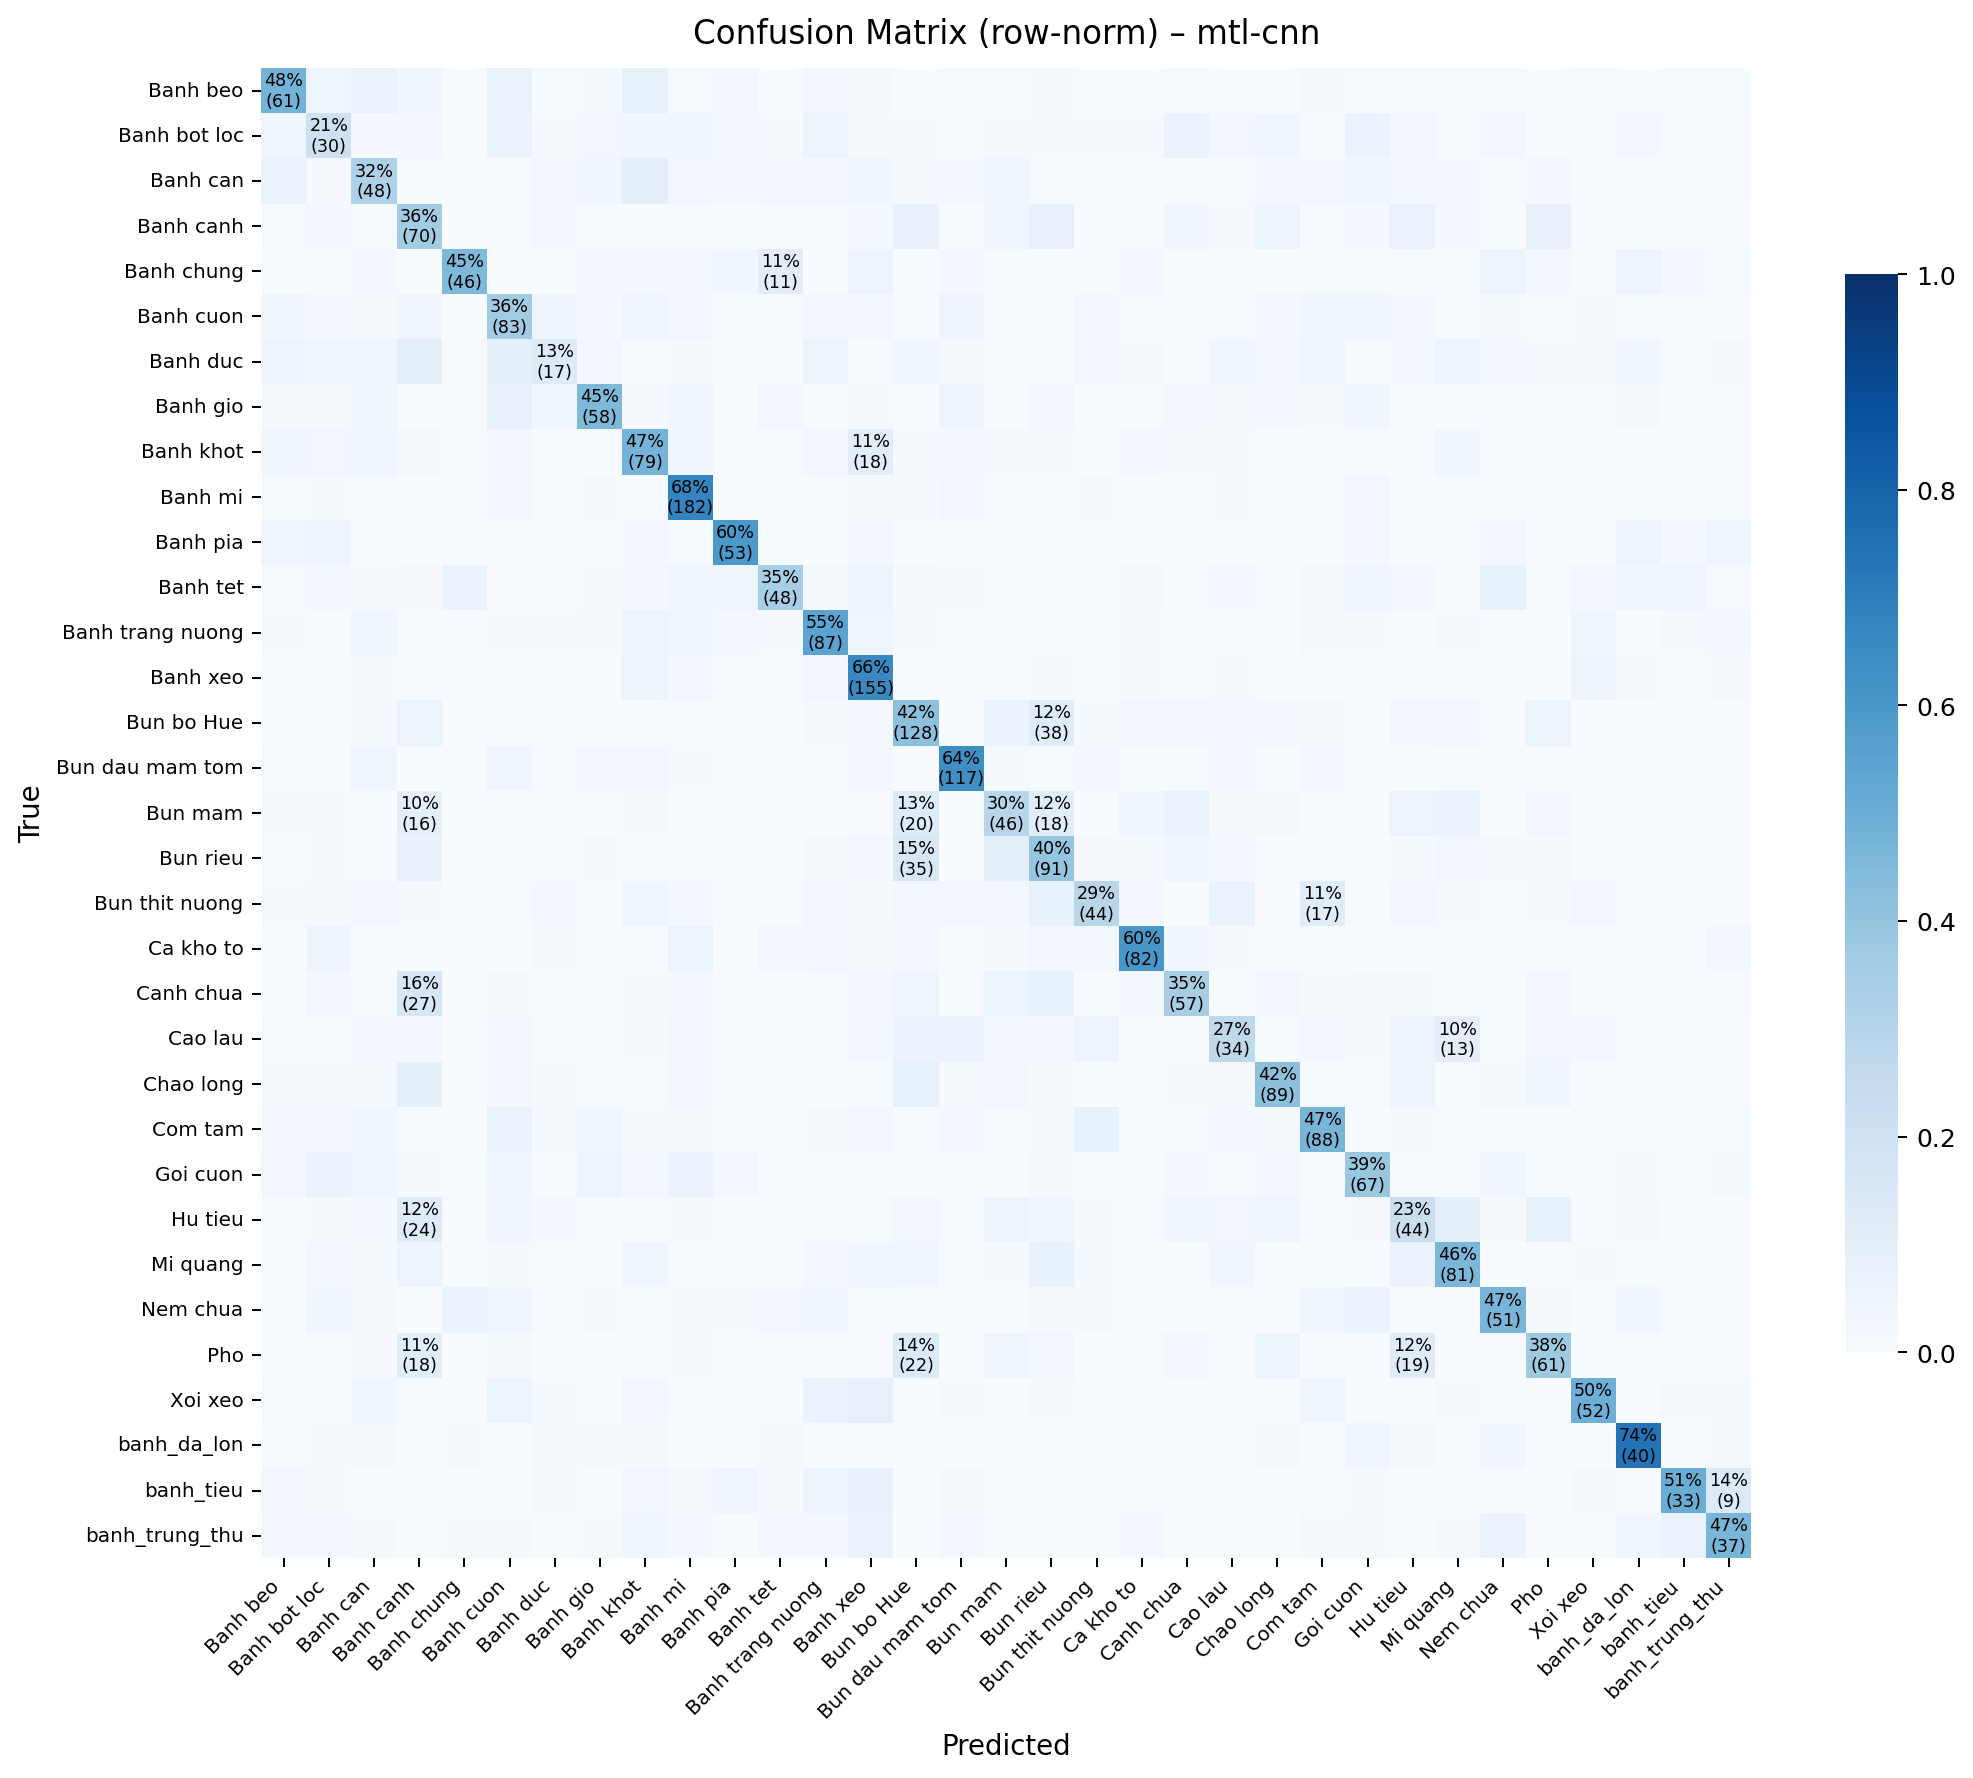

✓ Saved: ./images\mtl-cnn_cm.png


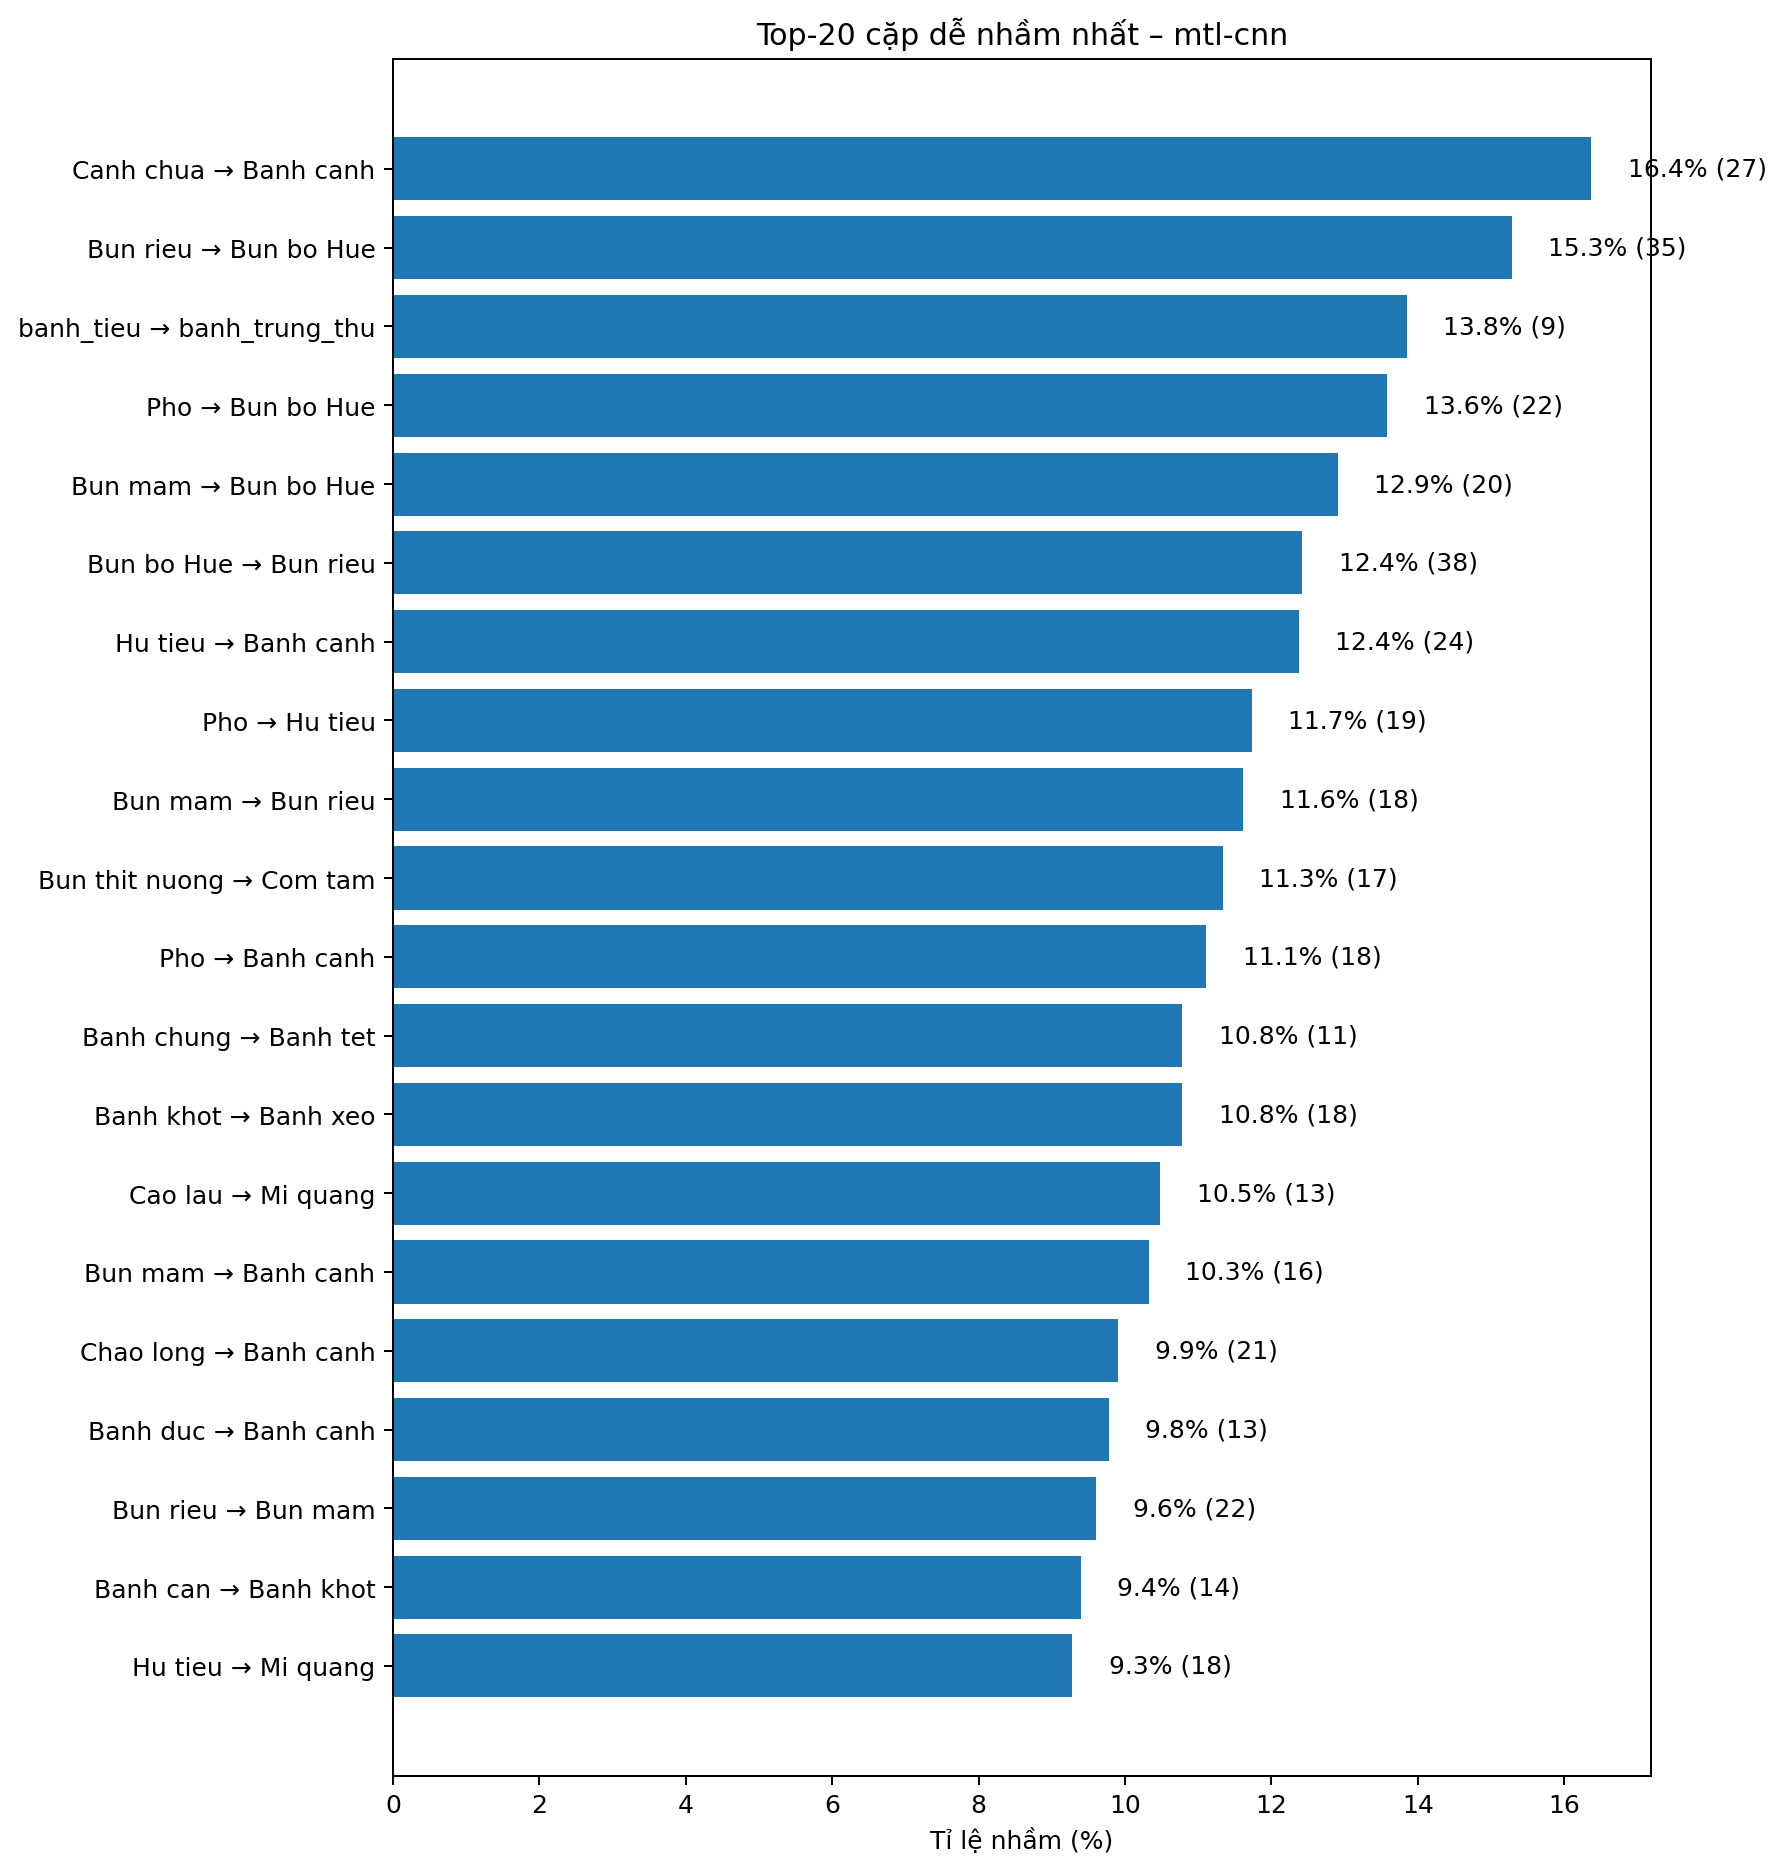

✓ Saved: ./images\mtl-cnn_top20_confused.png
Đánh giá: mtl-efficientnet_b0


C:\Users\Admin\AppData\Local\Temp\ipykernel_10156\395283910.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


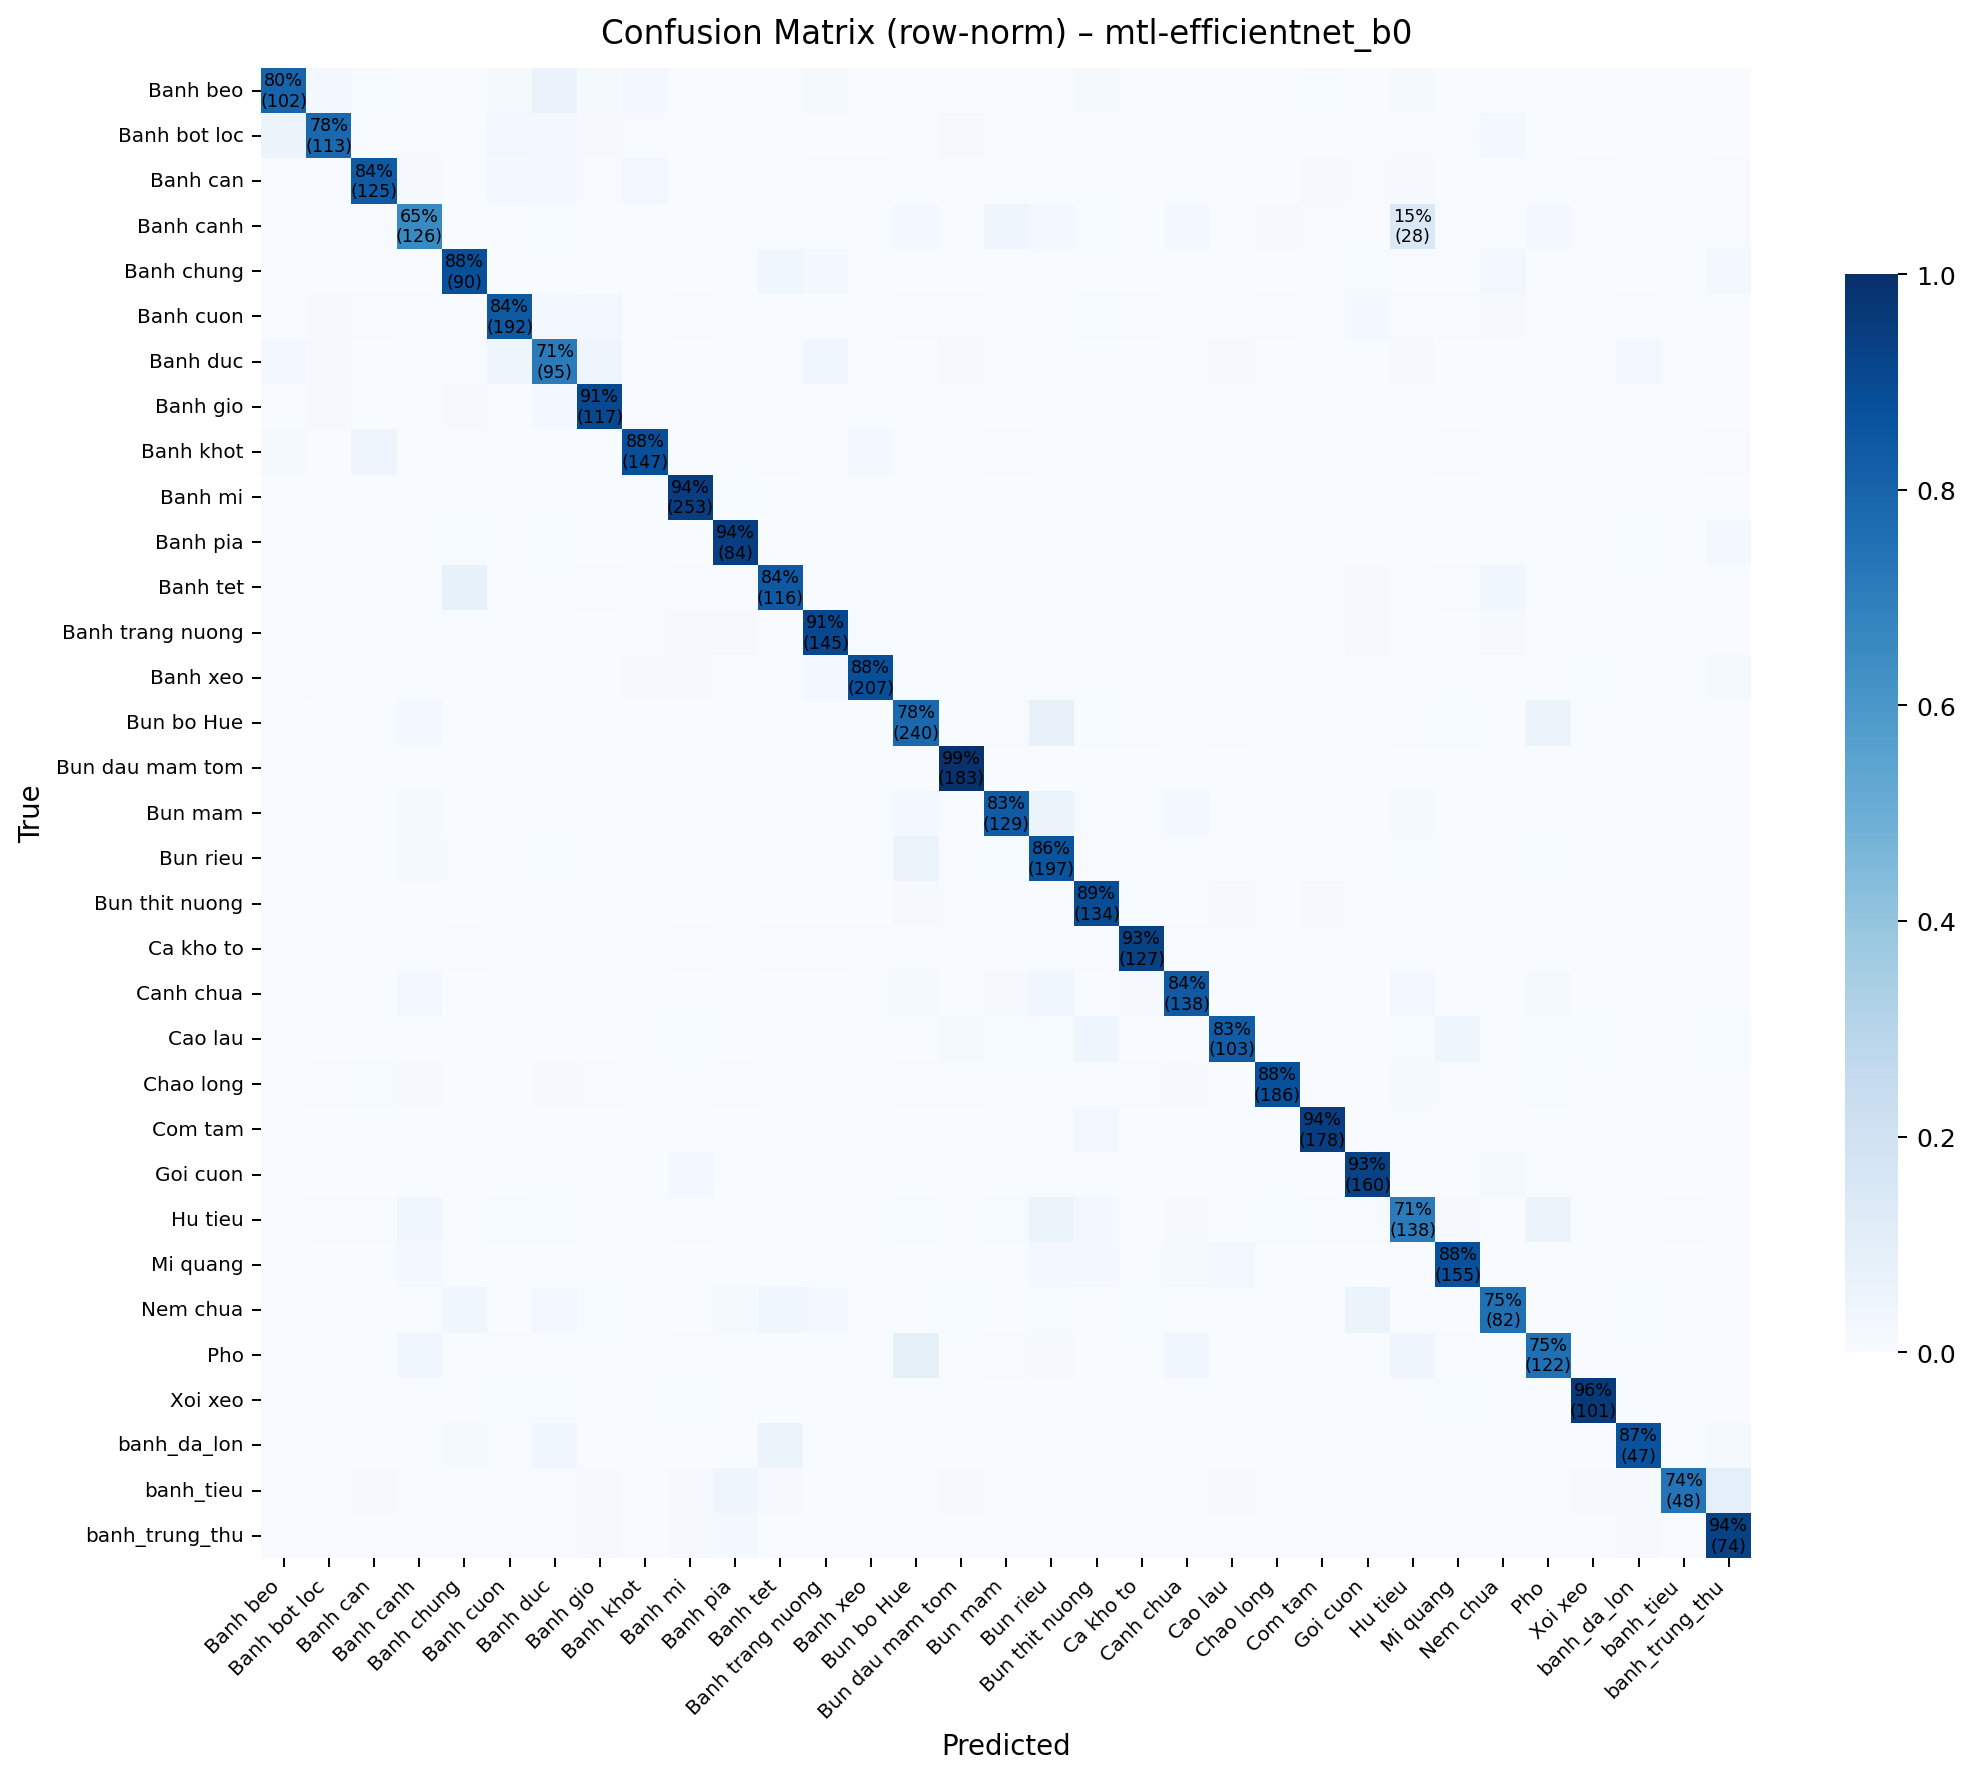

✓ Saved: ./images\mtl-efficientnet_b0_cm.png


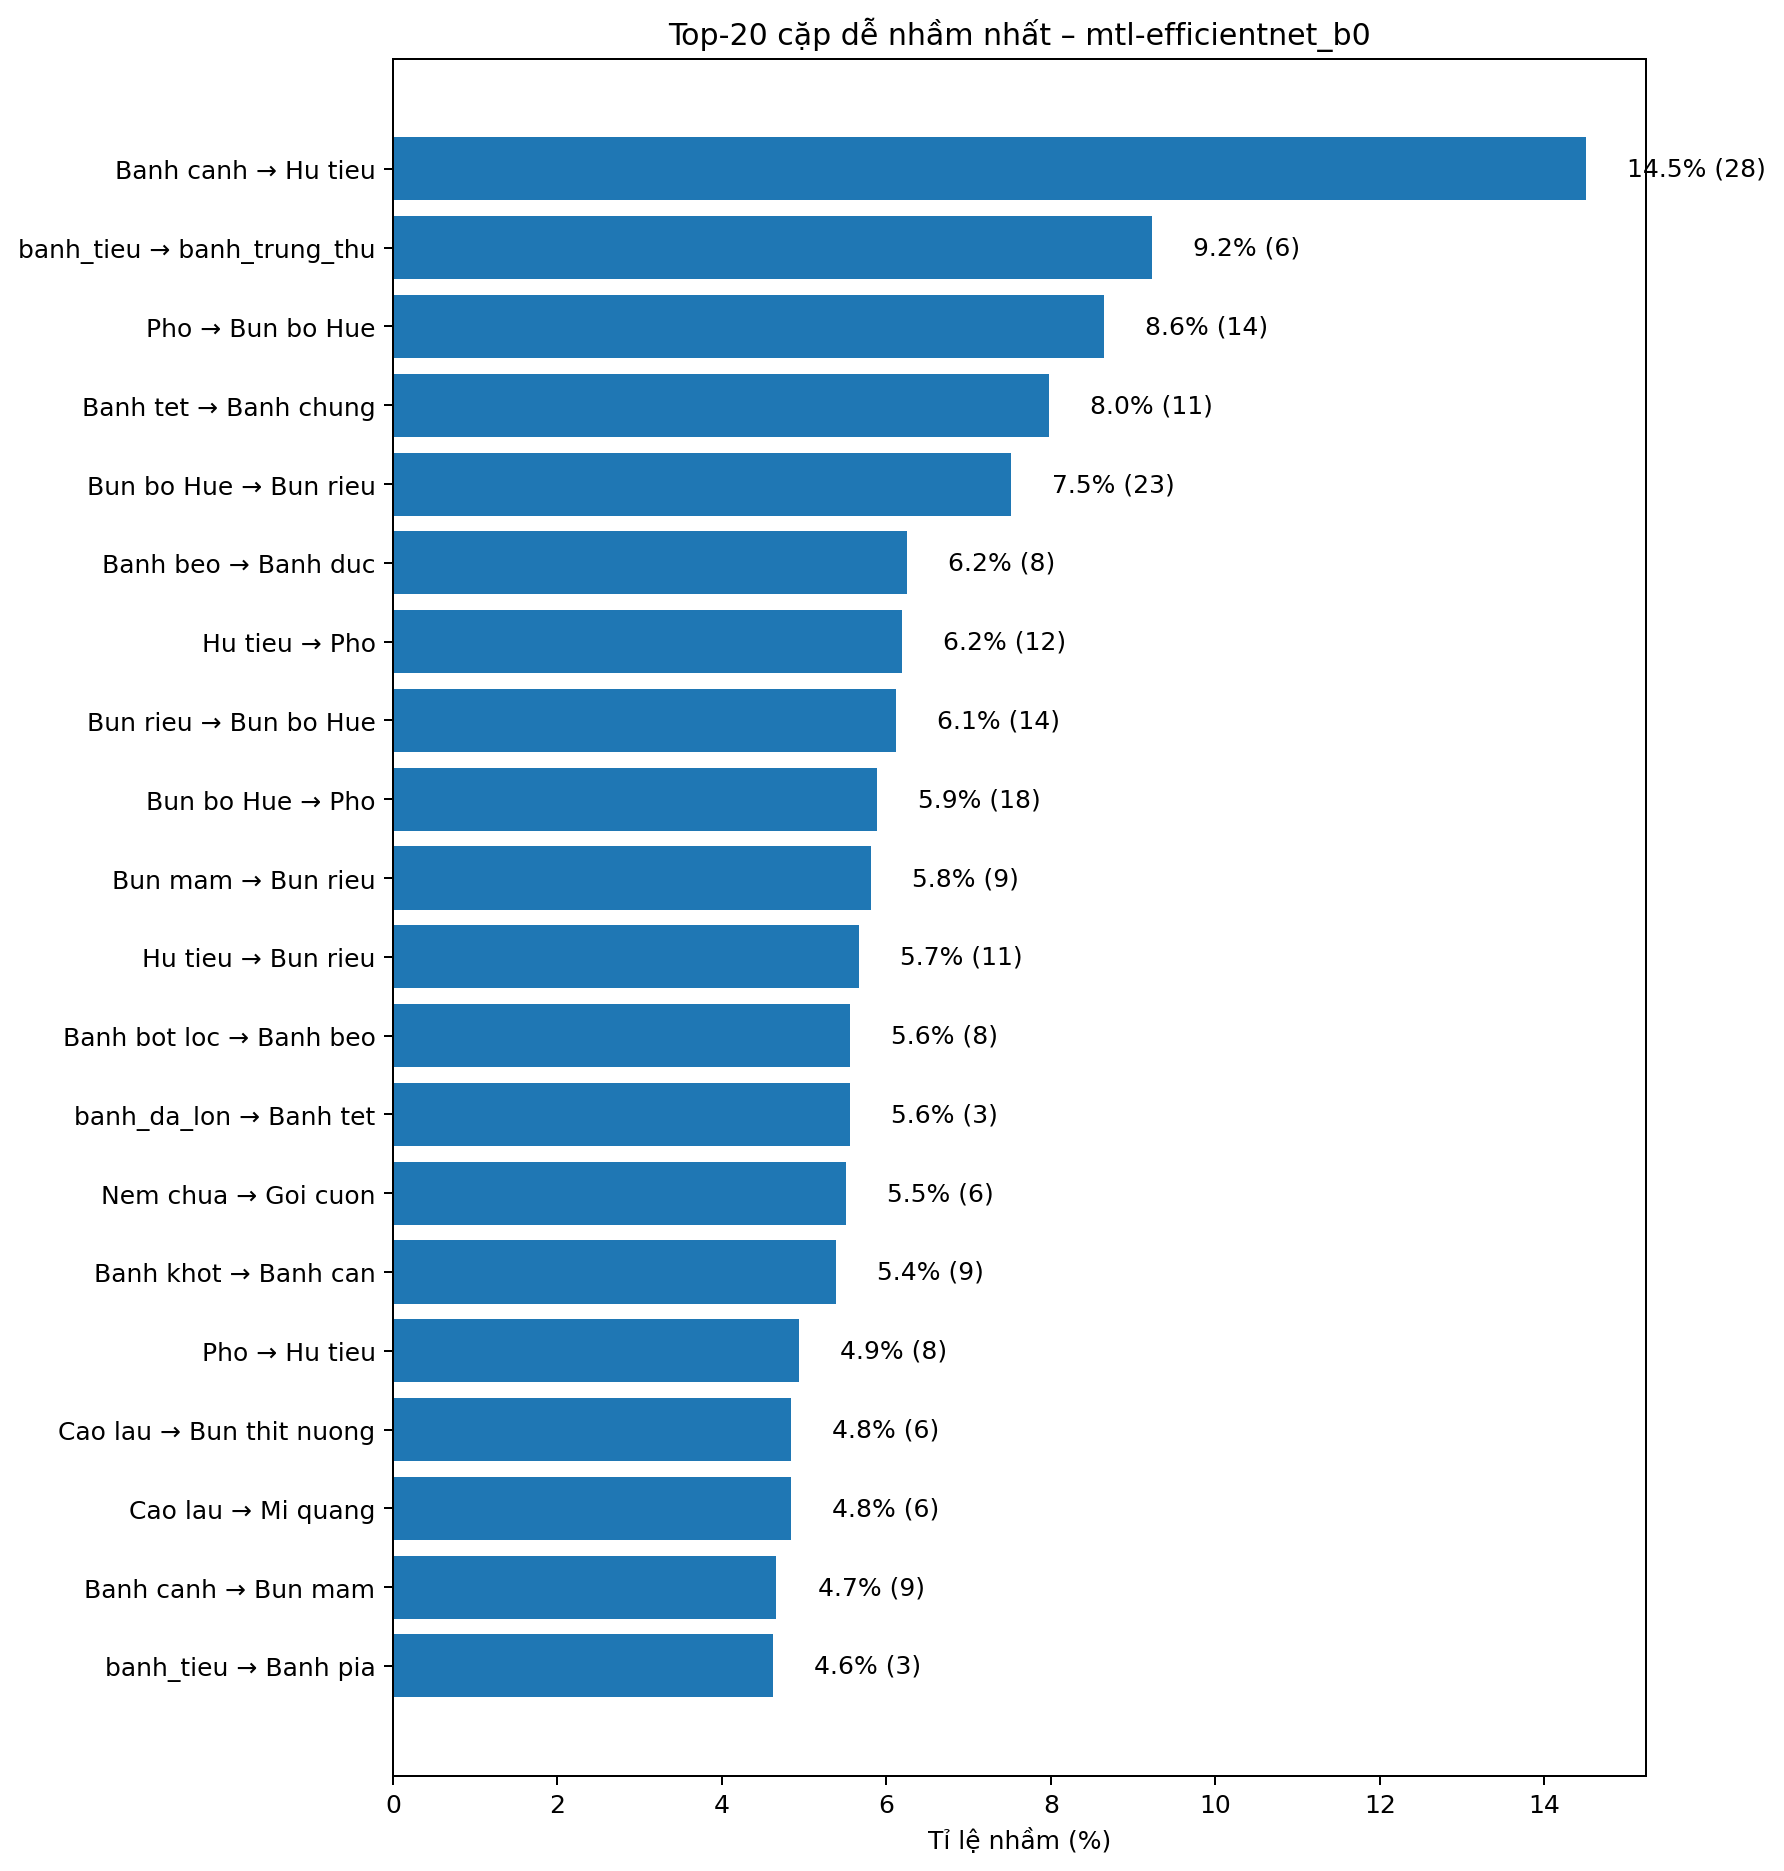

✓ Saved: ./images\mtl-efficientnet_b0_top20_confused.png
Đánh giá: mtl-mobilenetv4


C:\Users\Admin\AppData\Local\Temp\ipykernel_10156\395283910.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


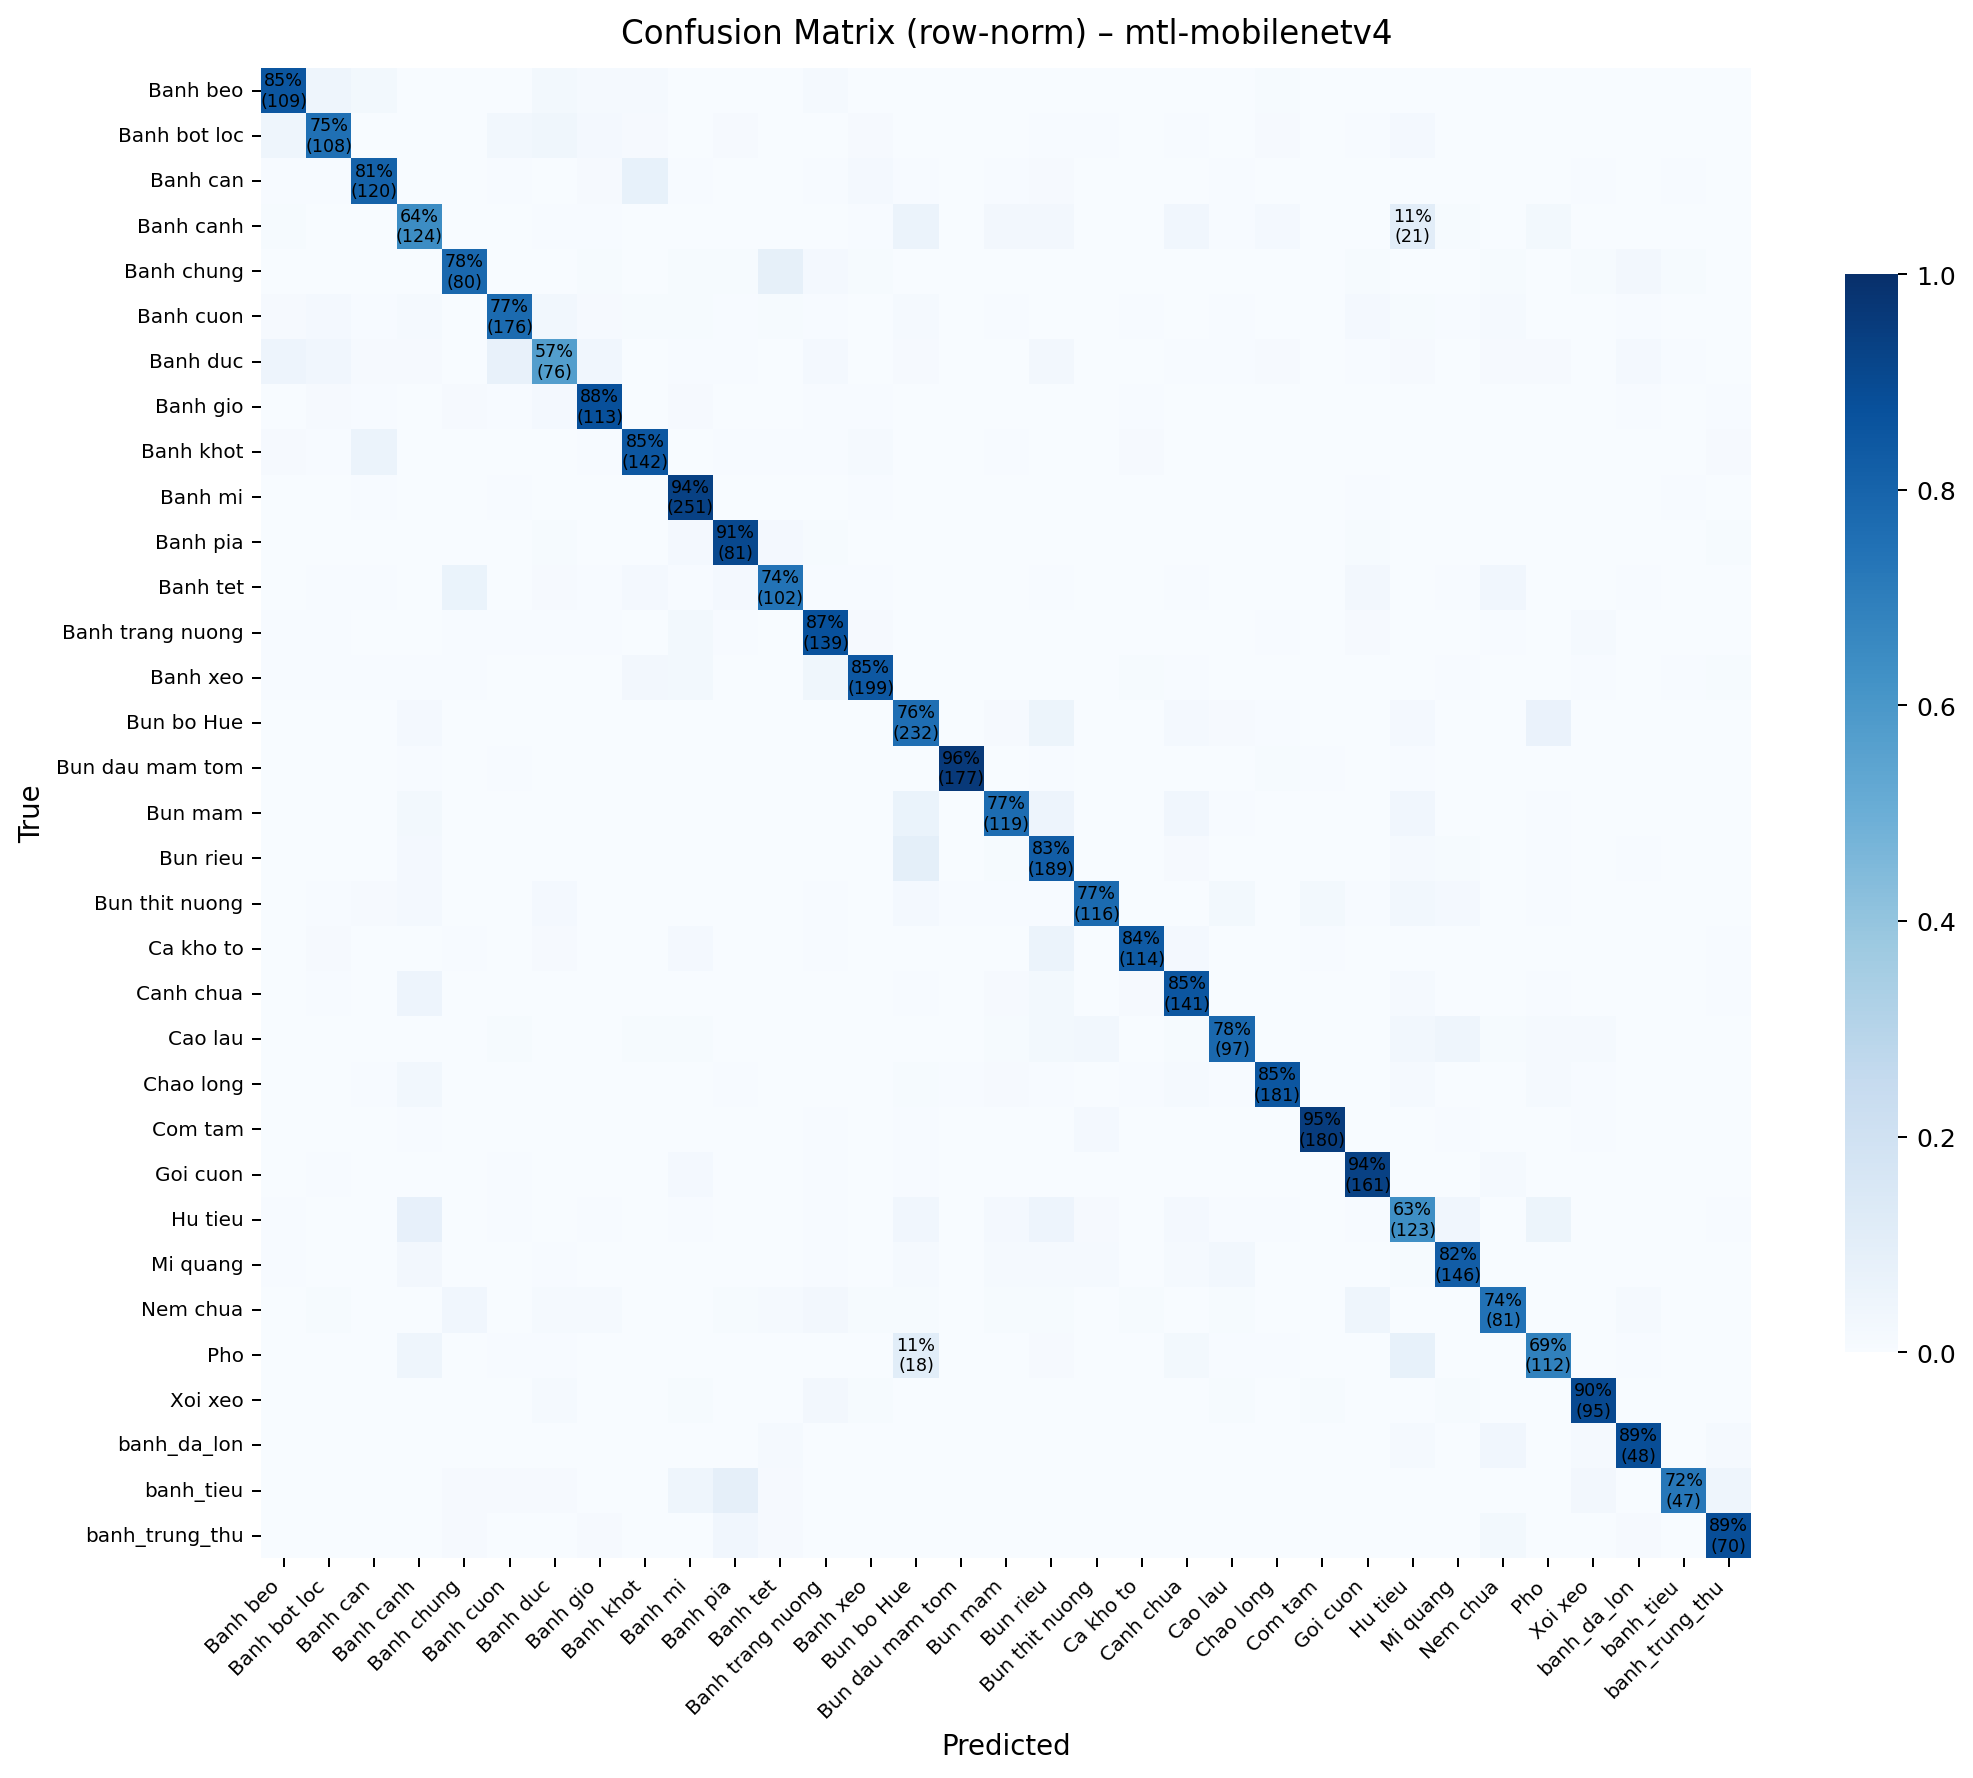

✓ Saved: ./images\mtl-mobilenetv4_cm.png


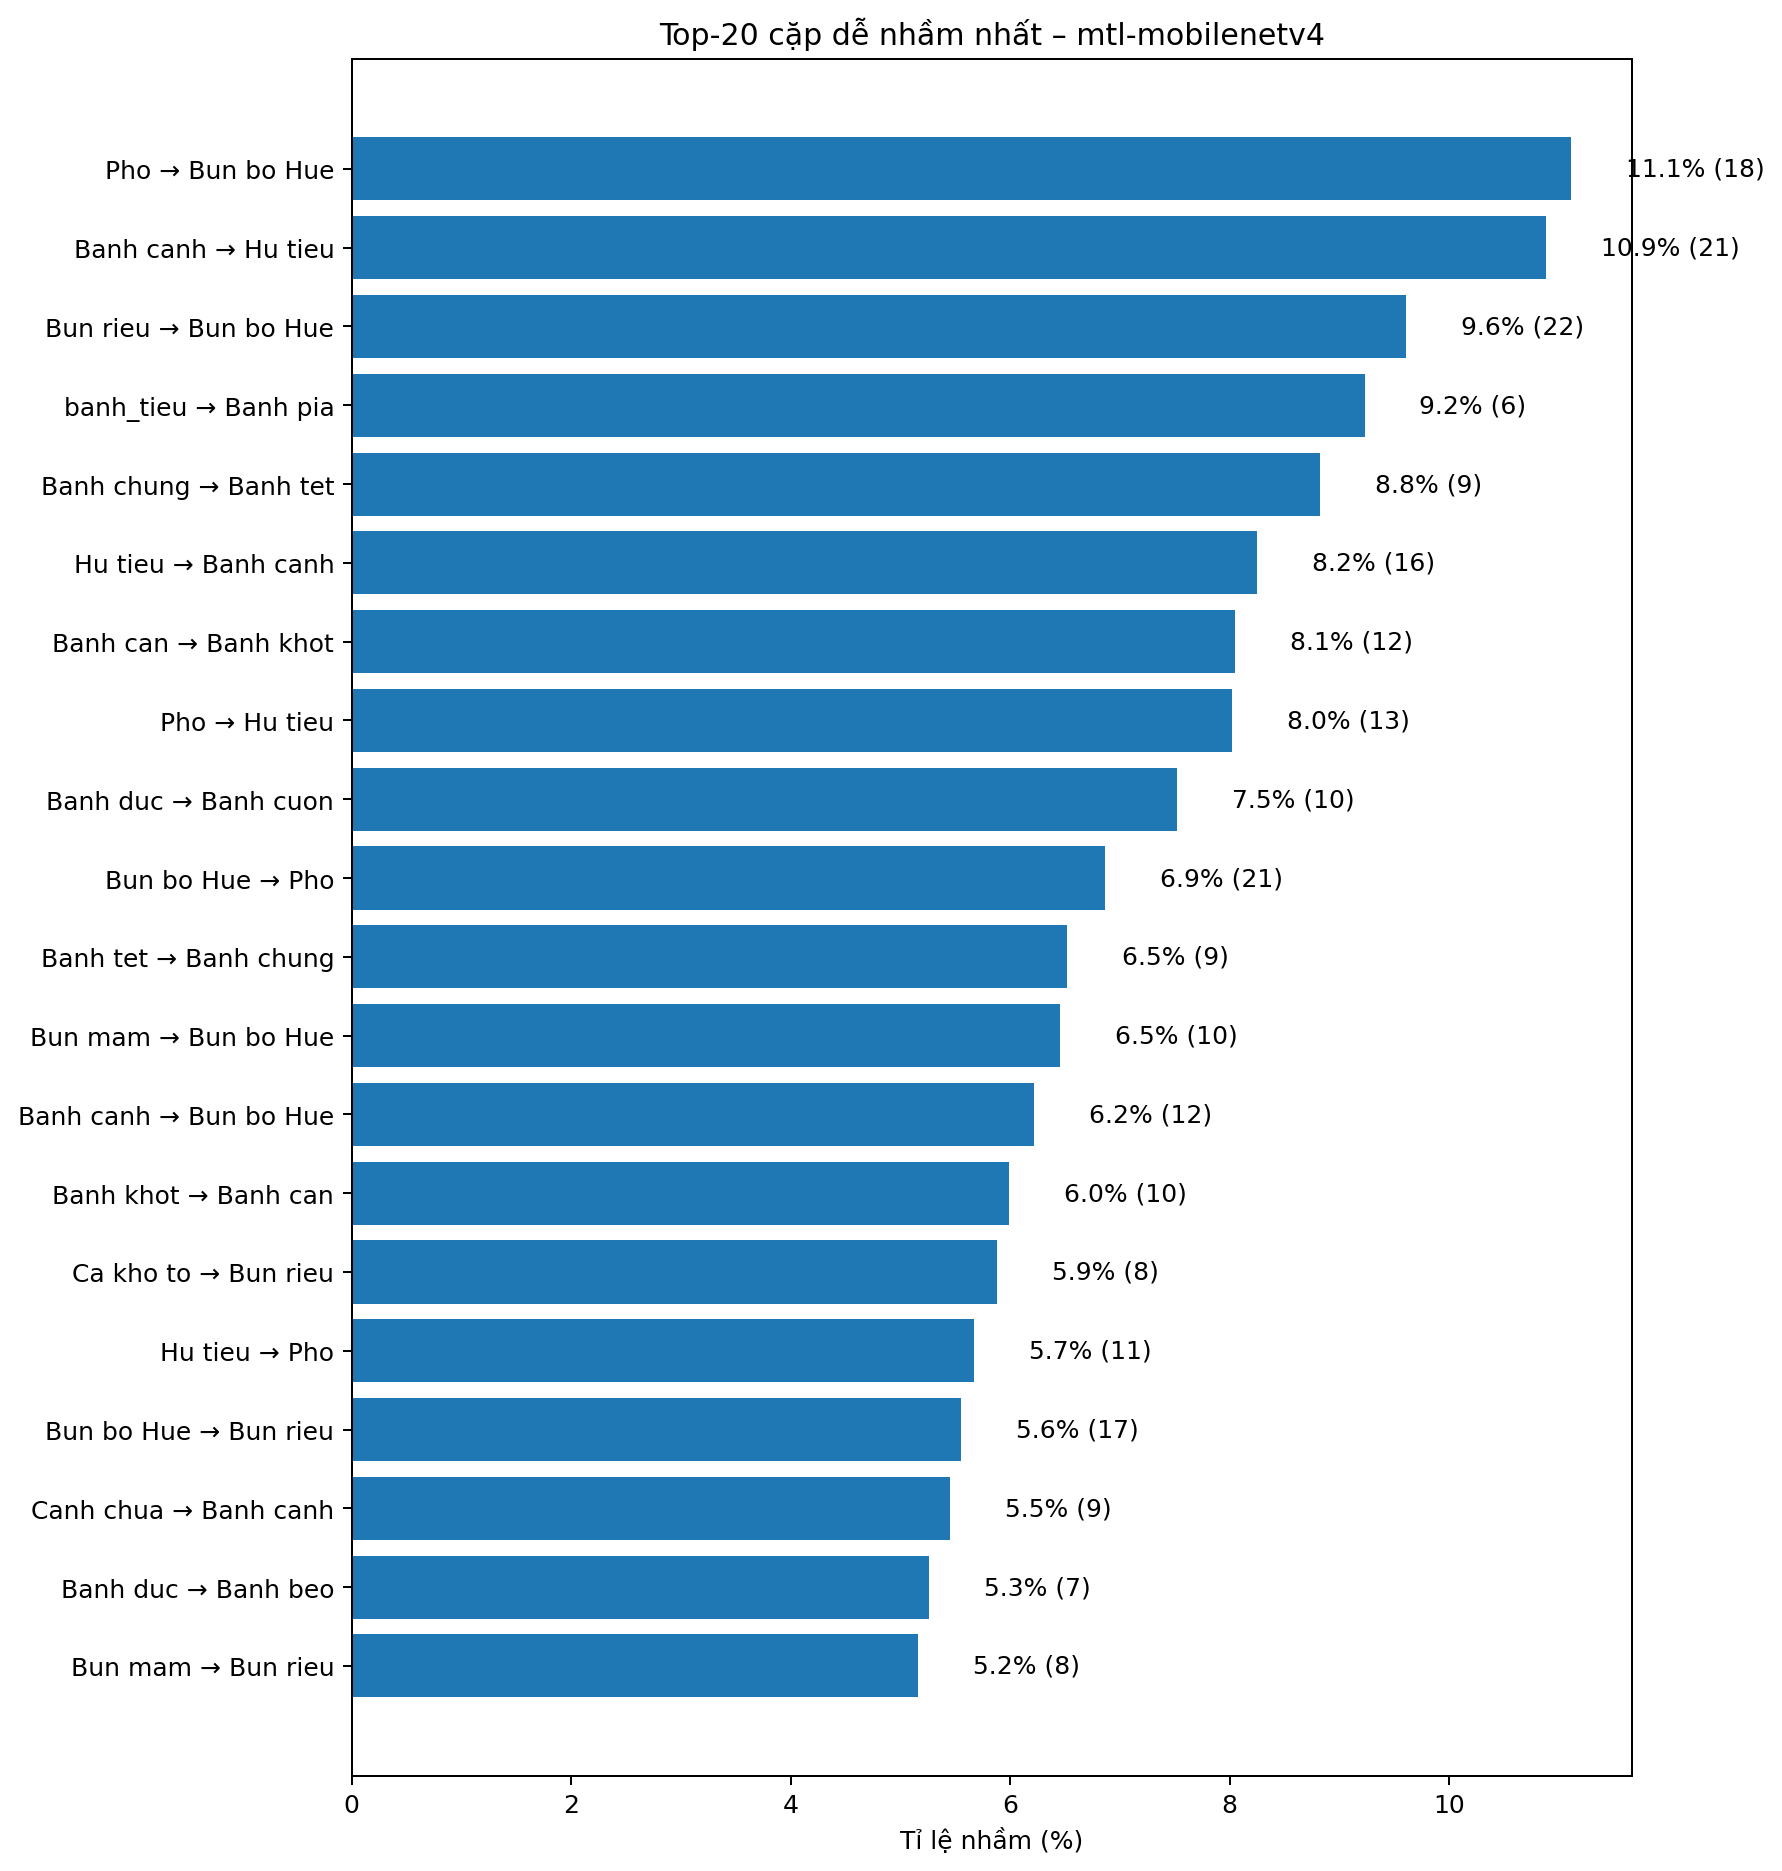

✓ Saved: ./images\mtl-mobilenetv4_top20_confused.png


,run,acc,precision,recall,f1,img_size,batch_size
1,mtl-efficientnet_b0,0.851788,0.851761,0.852588,0.850612,224,64
2,mtl-mobilenetv4,0.812584,0.815148,0.812428,0.812238,224,64
0,mtl-cnn,0.432014,0.434263,0.434682,0.430581,224,64


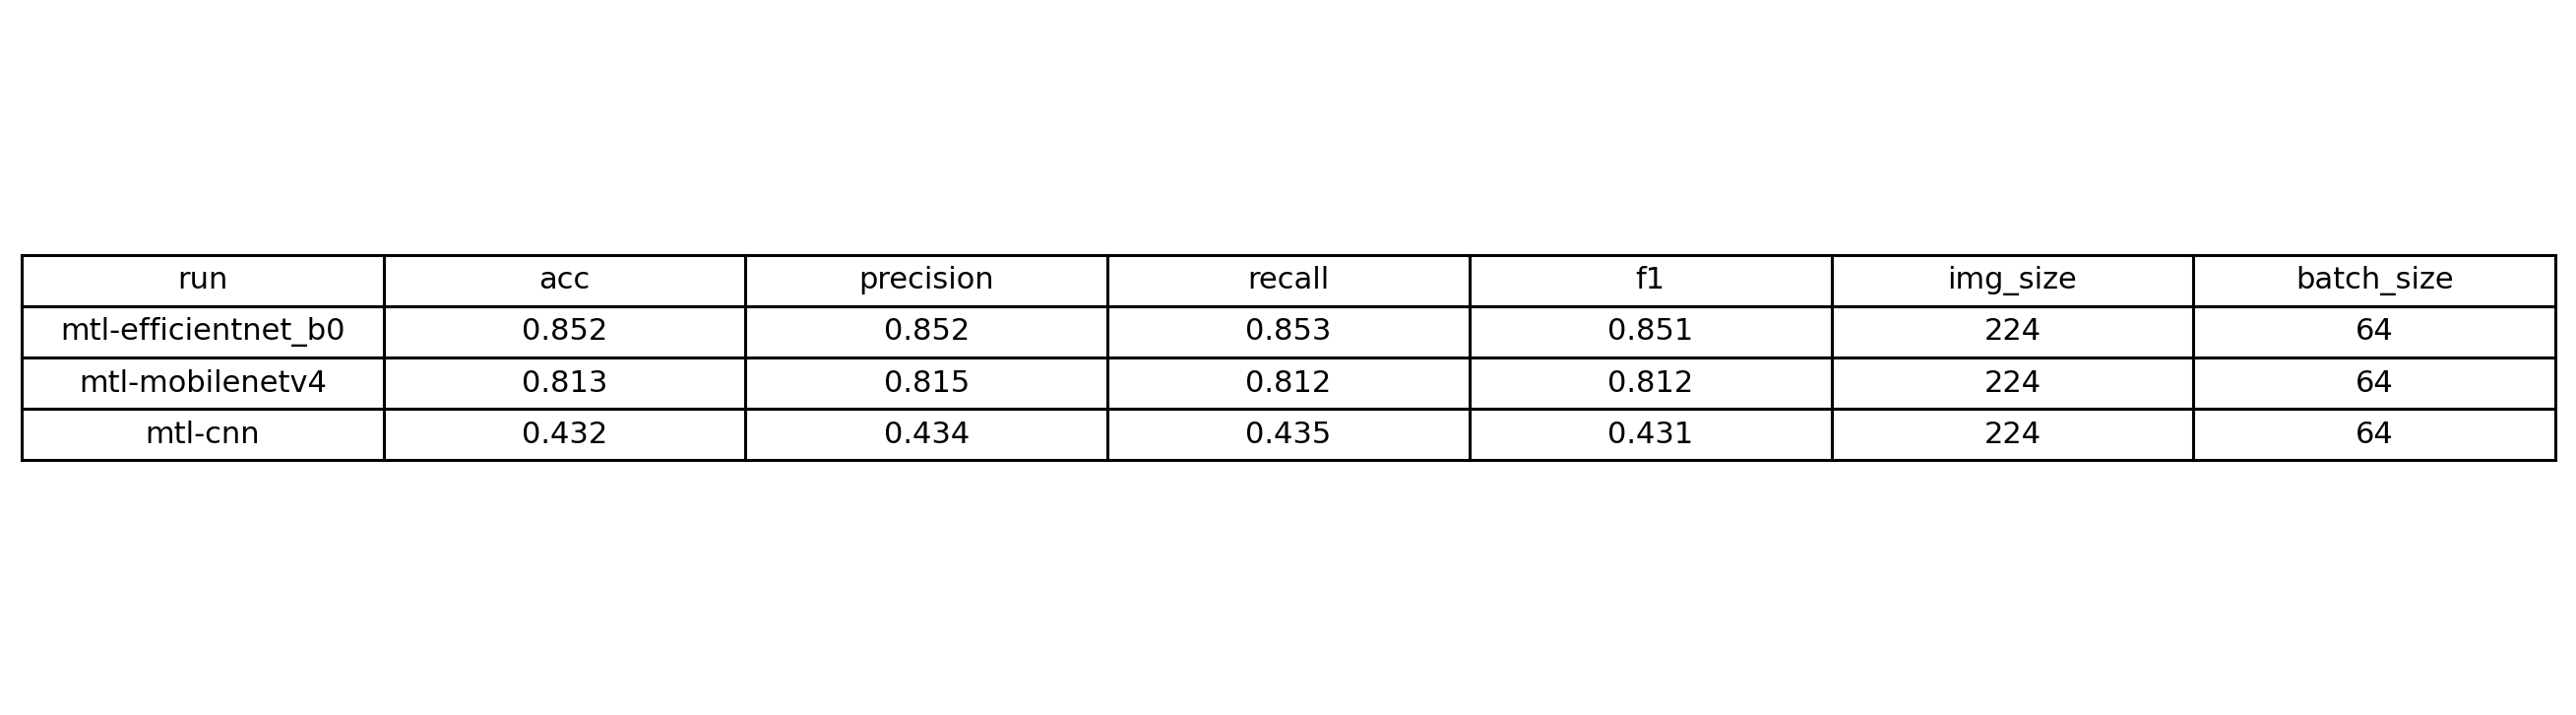

✓ Saved: ./images\summary_models.png


In [197]:
# === CELL 103: Đánh giá toàn bộ mô hình trong thư mục cha Runs/ ===
evaluate_entry(RUNS_DIR)